# Abstract
For this project, I will perform data analysis on Baltimore City crime data.  The motivation in exploring this data is to find patterns and trends in crimes so that we may learn more information and be better prepared to stop crime.  In the future we could even run some predictive analytics on the data to predict where/when/how a crime might happen next.  But, for the time being with this being an exploratory exercise we will look at patterns and trends in the data.  If they are aware of what is more likely to happen, they may be better prepared to prevent it before it does happen.

To perform this analysis, I will use a data set named "BPD Part 1 Victim Based Crime Data" from Open Baltimore (Here: https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij/data).  This data is updated every Monday, with a 9 day time lag to minimize changes to the data as records move throughout the BPD review process.  I exported this data as a CSV file and began the cleaning of it from there.  The data contains 16 columns and 313,634 rows.  This should be plenty of data to get a good idea of trends and potentially for predictive analytics as well.  One limitation for predictive analytics may be that this data is very qualitative, with most values being strings input into machine learning algorithms may be slightly more difficult depending on the algorithm.  A concern is also being able to perform exploratory analysis on things like the address and premise, as these may prove important but difficult to analyze at a large general scale.

Questions to be answered:
   * Is there a trend between time of day and number of crimes?
   * Is there a trend between the time of day and weapon used?
   * Is there a trend between the month of the year/season and the number of crimes?
   * Is there a trend between the day of the week and the number of crimes?
   * Is there a pattern in the number of crimes inside vs. outside based on the time of year?
   * Is there a pattern in the location of a crime (inside vs. outside) based on the weapon used?
   * Is there a pattern in the weapon used based on district?
   * Is a certain weapon more likely, given whether the crime was inside or outside?

Techniques:
I use pandas to import, clean, and explore the data after importing from excel into a dataframe.  The first step after reading the CSV file that was exported straight from Open Baltimore is to clean the data in preparation for analysis.

Cleaning the data:
The following are the steps, techniques and assumptions I used to clean the data:
1.  I use pandas read_csv to read the csv file which had a 'utf-8' encoding.
2.  I look at the column names to analyze which columns are good for answering our questions, and which contain duplicate information/ are not valuable and can be gotten rid of.  The techniques I use here are the pandas dataframe info() and head() functions to gain a better understanding of the data.  
3. I use the rename function with a lamda function to replace the spaces and slashes with an empty string to get rid of them.  
4. After looking at head(), I see that it looks like the TotalIncidents column is always 1, so I count the number of values in that column equal to one and turns out, it is the same number as there are rows (313,634), meaning they are all 1, which tells us nothing and this column may be dropped.  
5. It looks like the contents of the vri_name1 column are contained in the District column.  That, combined with the fact that there are only 37,056 non-null values in the vri_name1 column leads me to the decision that it can be dropped for simplicity and we will not really be missing any important information without having to do any further investigation.  
6. After looking at the output of the info() function, it is determined that the column, Location1, has 0 non-null values and can obviously be dropped.
7. I drop those 3 columns (Location1, vri_name1, TotalIncidents) using the pandas drop function.
8. Now that the columns are set, I look at handling the missing values and inconsistencies. The data has 313,634 entries.  I look at the output of the pandas info() function to gain more information from about the numbers of null values.  The columns of CrimeTime, Location, InsideOutside, Weapon, Post, District, Neighborhood, Longitude, Latitude, Premise all contain null values.  
    * The weapon column only had 66,908 non-null values, with so many nulls, I made the assumption that a null weapon means no weapon was used and filled them with 'None' using the pandas fillna function.
    * CrimeTime and Post each had small amounts of null values, and there is not a great way to fill them without introducing bias to the data.  For example, filling the missing times with midnight would increase the number of crimes at midnight to more than they should be when doing time analysis.  So, any row with a null for CrimeTime or Post, I drop.
    * The remaining columns of Location, InsideOutside, Neighborhood, and Premise are all strings and we can easily replace their nulls with 'Unknown' so that we can keep those data rows, and at the same time keep in mind that there are unknowns when doing the analysis.
9. I clean other inconsistencies such as FIRE to FIREARM and I to Inside, O to Outside.
10. I write the cleaned pandas dataframe to a csv file to be loaded from the explore workbook.  For the code of this cleaning, please see the load_and_clean workbook.

Now, onto the exploratory analysis of the data:

In [2]:
#imports
import numpy as np
import pandas as pd

In [4]:
#read in the raw csv file
crime_data = pd.read_csv("../data/cleaned_data.csv", encoding= 'utf-8')

In [5]:
#Now lets start exploring the data!
#first lets do some analysis on what effect the CrimeTime and CrimeDate has on the level of crimes
#We need to first convert the date and time from object to datetime64 to do more analysis on it
crime_data["CrimeDate"] = crime_data["CrimeDate"].astype("datetime64")
crime_data["CrimeTime"] = crime_data["CrimeTime"].astype("datetime64")

<AxesSubplot:title={'center':'Crimes per Hour'}, xlabel='Hour', ylabel='# Of Crimes'>

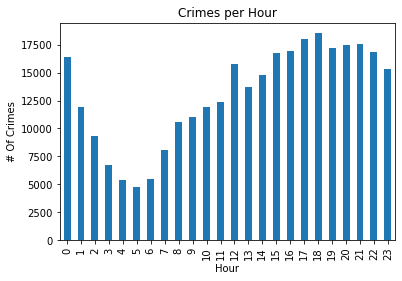

In [6]:
#Certain time of day crimes are more likely/common?
crime_data["CrimeTime"].groupby(crime_data["CrimeTime"].dt.hour).count().plot(kind="bar", title="Crimes per Hour", ylabel="# Of Crimes", xlabel="Hour")

The first question we look to answer is the trend between the time of day and the number of crimes that occur.  From the above visualization the trend is clear.  Crimes are at a minimum between 4am and 6am, rises relatively steadily throughout the day and then hits a maximum around 4pm with the number remaining higher through roughly 10pm, and another little spike around mindnight (12am/ hour 0).  The conclusion is that the number of crimes that happen is directly related to the number of people downtown in the city.  The peak times with a lot of people out and about in the city leads to more crime.  Between 4 and 6am, very few people are out and about, hence the minimum in crime.  There are a good amount of offices in downtown Baltimore, and most people get out of work between 4pm and 6pm, hence the maximum in the number of crimes around then.  Finally, the last little spike around midnight can be interpreted as a time when it is dark and still early enough that many people who are looking for trouble may still be out.  This leads to another potentially interesting question, do the crimes that take place at midnight tend to be more violent as in shootings and knives compared to crimes that happen to more of the business type people between 4pm and 6pm?  We investigate next:

In [11]:
#Let's create a function that creates the df with counts to avoid code duplication:
def create_counts_df(group_x_axis, group_y_axis):
    counts_df = None #initialize here for scope
    if(group_x_axis == "CrimeDate"): #if looking at the date, look at the month
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis].dt.month, crime_data[group_y_axis]]).count()
    elif(group_x_axis == "CrimeTime"): #if looking at the time, look at the hour
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis].dt.hour, crime_data[group_y_axis]]).count()
    else: #otherwise, just use the value in the data
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis], crime_data[group_y_axis]]).count()
    counts_df = counts_df.to_frame()
    counts_df.columns = ["Count"]
    counts_df = counts_df.reset_index()
    return counts_df

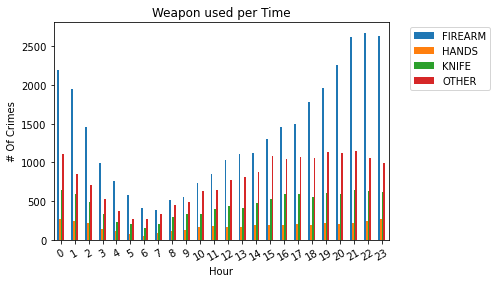

In [24]:
#Lets see if there are patterns for weapon based on time
weapon_time_df = create_counts_df("CrimeTime", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
weapon_time_df = weapon_time_df[weapon_time_df.Weapon != 'None']

ax = weapon_time_df.pivot(index='CrimeTime', columns='Weapon').plot(kind='bar', title="Weapon used per Time", ylabel="# Of Crimes", xlabel="Hour", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARM', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

Based on the visulaization, it looks like the times do indeed have an impact on the weapon type used.  The biggest takeaway looks to be that firearms are used more in the later hours of the night.  Take a look at the hours 15-23 - the level of crimes for using hands, knife, and other remain relatively constant but the use of firearms increases dramatically during this time frame.  This shows that after dark, it is more likely that a firearm may be used and police should be aware of this trend to be prepared for potential crimes involving firearms at that time.

<AxesSubplot:title={'center':'Crimes per Month'}, xlabel='Month', ylabel='# Of Crimes'>

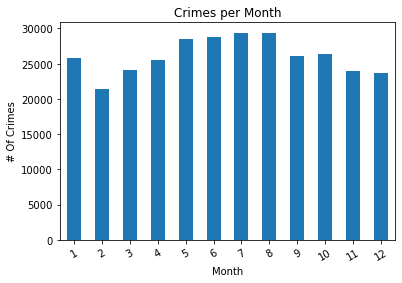

In [25]:
#Certain months crimes are more likely/common?
crime_data["CrimeDate"].groupby(crime_data["CrimeDate"].dt.month).count().plot(kind="bar", title="Crimes per Month", ylabel="# Of Crimes", xlabel="Month", rot=30)

Based on the visualization above, we can clearly see that crimes tend to happen more frequently around the middle of the year in months 5-7 (May-July).  The theory behind this is that more people are out and about during these months as the weather is warmer.  Crimes tend to decrease over the winter months as more people tend to stay indoors or home during these times.

<AxesSubplot:title={'center':'Crimes per Day'}, xlabel='Day of Week', ylabel='# Of Crimes'>

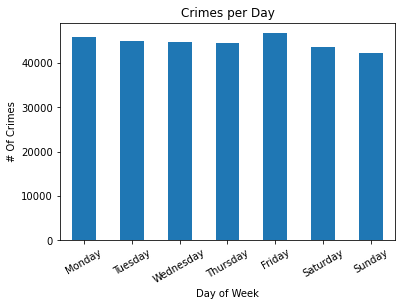

In [27]:
#Certain day of the week crimes are more likely/common?
day_of_week_df = crime_data["CrimeDate"].groupby(crime_data["CrimeDate"].dt.dayofweek).count()
day_of_week_df.index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_df.plot(kind="bar", title="Crimes per Day", ylabel="# Of Crimes", xlabel="Day of Week", rot=30)

When looking at crimes spread across the days of the week, we see that there is not too much of a discrepancy.  I would have expected the crimes to be higher on the weekend as I would have suspected that more people would have been out and about.  The data shows the contrary, and a possible explanation could be that this data is for Baltimore city, which does have a good amount of office buildings that hold a lot of people who are downtown for weekdays, and not on weekends.  Contrary to what I originally thought, it may be true that there is actually less people in Baltimore during the weekends.  This data shows that, if anything, police should be prepared to stop just as much if not more crime during the weekdays than the weekends.  And, if it is a lot of business people being targeted, should be aware and be prepared outside business buildings to stop these crimes before they happen.

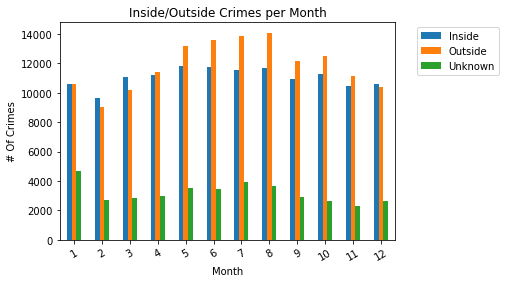

In [29]:
#Great, now lets see if there are patterns for inside/outside based on month of year
month_df = create_counts_df("CrimeDate", "InsideOutside")

ax = month_df.pivot(index='CrimeDate', columns='InsideOutside').plot(kind='bar', title="Inside/Outside Crimes per Month", ylabel="# Of Crimes", xlabel="Month", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['Inside', 'Outside', 'Unknown']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

The data proves that depending on the time of year, they should be more prepared to stop crimes inside vs. outside.  For the warmer months of 4-11 (April - November) the number of crimes outside is higher than those inside.  For the other colder months of 12-3 (December - March) crimes inside vs. outside tend to have about the same or higher likelihood to be inside as they do outside.  The conclusion to be drawn here is that police should expect less crime outside during the colder months, and focus more resources on preventing the outside crime in the warmer months of the year.

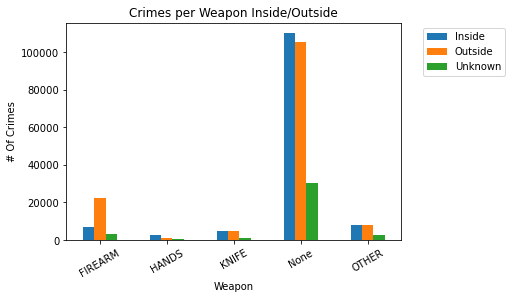

In [30]:
#Lets see if there are patterns for weapon based on inside/outside
weapon_I_O_df = create_counts_df("Weapon", "InsideOutside")

ax = weapon_I_O_df.pivot(index='Weapon', columns='InsideOutside').plot(kind='bar', title="Crimes per Weapon Inside/Outside", ylabel="# Of Crimes", xlabel="Weapon", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['Inside', 'Outside', 'Unknown']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

Next, we analyze the trends of crimes inside vs. outside based on the weapon used.  From the visualization we see that when a firearm is used, it is more often than not used outside.  On the other hand, when hands are used it is more often than not used inside.  So, if police get reports of a shooting, there is a higher likelihood that they should be looking for the suspect outdoors.  If there is a report of a crime involving hands, they should be more prepared to handle and indoors crime.  This also says that if an officer is on duty outside, they should be better prepared for a shooting than officers inside - police more suited for shootings should be placed on duty in the outdoors.  This is important, because with shootings the severity of the crime may be escalated to a life or death situation and repsonding well to these could save lives.

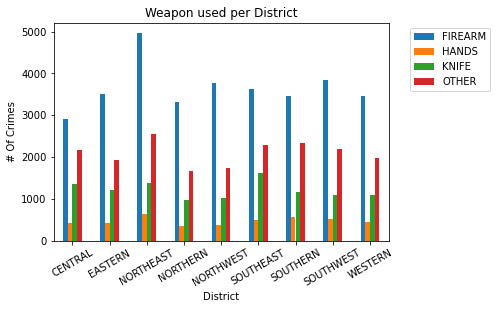

In [31]:
#Lets see if there are patterns for weapon based on District
weapon_district_df = create_counts_df("District", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
weapon_district_df = weapon_district_df[weapon_district_df.Weapon != 'None']

ax = weapon_district_df.pivot(index='District', columns='Weapon').plot(kind='bar', title="Weapon used per District", ylabel="# Of Crimes", xlabel="District", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARM', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

The goal with this visualization is to determine whether or not there is a trend between district and the weapon used.  For example, do firearms tend to be used more frequently in the souther district as opposed to the western?  The data shows that each district looks about even in their distribution of weapon used.  None of them really stick out, the northeast has the highest usage of firearms by far, but they also have more crime in general with the other weapons as well (perhaps the northeast district is larger and hence results in more crime).  The conclusion here is that police in all districts should be able to handle all of these types of crime and the type of crime that occurs does not really depend on the district.

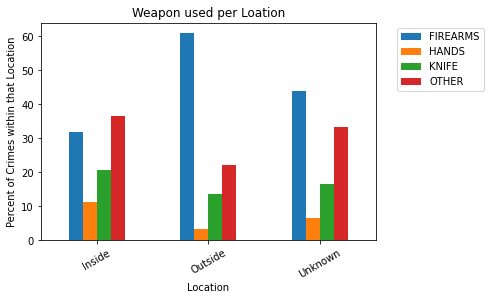

In [32]:
#Lets see if there are patterns for weapon based on InsideOutside
I_O_weapon_df = create_counts_df("InsideOutside", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
I_O_weapon_df = I_O_weapon_df[I_O_weapon_df.Weapon != 'None']

#get some percentages, counts are less relevant, given inside/oustide what pct of crimes use that weapon?
#of the crimes that happen inside:
sum_outside = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Outside']['Count'].sum()
sum_inside = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Inside']['Count'].sum()
sum_unknown = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Unknown']['Count'].sum()

def generate_pcts(I_O_weapon_df):
    pcts = []
    for index, row in I_O_weapon_df.iterrows():
        if(row['InsideOutside'] == "Inside"):
            pcts.append((row["Count"]/sum_inside)*100)
        elif(row['InsideOutside'] == "Outside"):
            pcts.append((row["Count"]/sum_outside)*100)
        else:
            pcts.append((row["Count"]/sum_unknown)*100)
    return pcts

I_O_weapon_df['pcts'] = generate_pcts(I_O_weapon_df)

ax = I_O_weapon_df.pivot(index='InsideOutside', columns='Weapon', values='pcts').plot(kind='bar', title="Weapon used per Loation", ylabel="Percent of Crimes within that Location", xlabel="Location", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARMS', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

Building off the previous finding that firearms tend to be used outside, this time we look at the percentages of weapon used based on the location of inside vs. outside.  These findings agree with our previous findings.  Given that a crime is outside, over 60% of the time, a firearm was used, whereas a knife ~15% of the time, and hands ~5% of the time.  On the other hand, when a crime is commited inside, a firearm was used roughly 33% of the time, knife ~20% and hands ~10%.  Police should have these numbers in mind when stationed to spot crime to know what is likely to happen given the location/scenario they are in.

In [33]:
#Lets see if there are patterns for the crime description based on the premise
#Utilizing these results may be extremely valuable, but is also a challenge as there are a lot of unique premises.
#Given a specific premise, police could use this information to see which crime description is most likely.
premise_description_df = create_counts_df("Premise", "Description")
print(premise_description_df)

           Premise           Description  Count
0            ALLEY          AGG. ASSAULT    360
1            ALLEY                 ARSON     58
2            ALLEY            AUTO THEFT    402
3            ALLEY              BURGLARY     34
4            ALLEY        COMMON ASSAULT    198
..             ...                   ...    ...
903  YARD/BUSINESS                  RAPE      1
904  YARD/BUSINESS  ROBBERY - CARJACKING      4
905  YARD/BUSINESS  ROBBERY - COMMERCIAL     23
906  YARD/BUSINESS   ROBBERY - RESIDENCE      2
907  YARD/BUSINESS      ROBBERY - STREET      3

[908 rows x 3 columns]


# Challenges
One of the challenges to exploring this data is finding trends that are specific down to a specific premise or address.  There are so many unique premises and addresses that analyzing each and everyone of these situations is difficult.  Though it may be more difficult to visualize and analyze, the results can still be extremely helpful to police.  Having the likelihood of each crime available given a premise is available, and a police officer would have that information readily available upon request.

# Conclusions
Each question was answered through analysis of the data. In summary:
* There is a trend between the time of day and the number of crimes, with the minimum amounts of crime happening between 4am and 6am, rising relatively steadily throughout the day and then hits a maximum around 4pm with the number remaining higher through roughly 10pm, and another little spike around mindnight (12am/ hour 0).  In general crimes tend to peak when the highest number of people are out and about.
* There is a trend between time of day and weapon used - the biggest takeaway is that firearms are used more in the later hours of the night.
* There is a trend between month of the year/season and the number of crimes - warmer months tend to have more crime.  As more people tend to stay put and indoors in the colder months, less crime takes place.
* There is not a deliberate trend between day of the week and crime - if anything, slightly more crime happens during the week and we say that this may be due to the fact that Baltimore may be higher populated during the week as all the business professionals work weekdays.
* There is a pattern in the number of crimes inside vs. outside based on the time of year - in the warmer months more crimes take place outside; in the colder months, more crime tends to take place indoors.
* There is a pattern in the location of the crime based on the weapon used. When a firearm is used, it is more often than not used outside. On the other hand, when hands are used it is more often than not used inside.  So, police should be aware of this fact and understand when a call for a shooting comes in, it is likely an outdoor act.
* There is not a distinct pattern in the weapon used based on district - each district has a relatively similar distribution of weapons used, and police of all types should exist in all districts.
* There is a pattern in the location (inside vs. outside) and the weapon used - given that a crime is outside, over 60% of the time, a firearm was used, whereas a knife ~15% of the time, and hands ~5% of the time. On the other hand, when a crime is commited inside, a firearm was used roughly 33% of the time, knife ~20% and hands ~10%. Police should have these numbers in mind when stationed to spot crime to know what is likely to happen given the location/scenario they are in.